## Imports

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

## Functions

### Plotting and Helpers

In [2]:
def reorderPairs(vals,lbls,filter=False):
    data = [(v,l) for v,l in zip(vals,lbls) if not filter or not(v==0.0)]
    data.sort(reverse=True,key=lambda pair: pair[0])
    return (list(t) for t in zip(*data))
     

def genPiePlot(vals, labels, title="", filter=False, colors=None):
    vals, labels = reorderPairs(vals,labels,filter)
    explode = [0]*len(vals)
    explode[-1] = 0.1
    plt.figure(0,figsize=(9,12))
    if colors == None:
        plt.pie(vals,labels=labels,autopct='%1.1f%%',
                pctdistance=.9, shadow = True, explode=explode)
    else:
        plt.pie(vals,labels=labels,autopct='%1.1f%%',
                pctdistance=.9, shadow = True, explode=explode,colors=colors)
    if title: plt.title(title)
    plt.show()


def plot_hist(val_hist, adiv_hist, invest_alloc_hist, ysr, snowBallCutOff, years):
    # Calculate cumulative investment growth from invest_alloc_hist
    invest_hist = [sum(ia) for ia in invest_alloc_hist]
    cumulative_investment_growth = np.cumsum(invest_hist)
    invest_hist = invest_hist[:-1]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Portfolio Value Growth over Time
    ax1.plot(list(range(len(val_hist))), val_hist, label='Value', color='blue', alpha=0.6)
    ax1.set_xlabel('Years Invested')
    ax1.set_ylabel('Portfolio Value (€)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    scale = np.array(range(max(int(100000*round(min(val_hist)/100000))-100000,0), int(max(val_hist))+100000, 500000))
    ax1.set_yticks(scale)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,7))

    # Plot cumulative investment growth on primary y-axis as a dashed red line
    ax1.plot(range(len(cumulative_investment_growth)), cumulative_investment_growth, 
             label='Cumulative Investment', color='red', linestyle='--')
    ax1.legend(loc='upper left')
    
    # Plot Portfolio Dividend Growth over Time
    ax2 = ax1.twinx()
    ax2.plot(list(range(len(adiv_hist))), adiv_hist, label='Dividend', color='darkgreen', alpha=0.6)
    ax2.set_ylabel('Dividend in €', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    scale = np.array(range(int(10000*round(min(adiv_hist)/10000)), int(max(adiv_hist)+10000), 10000))
    ax2.set_yticks(scale)

    # Plot yearly investment amounts as red bars on the secondary y-axis
    ax2.bar([num+0.5 for num in range(len(invest_hist))], invest_hist, color='red', alpha=0.3, label='Yearly Investment')
    ax2.bar([num+0.5 for num in range(snowBallCutOff)], [ysr for _ in range(snowBallCutOff)],color='black',alpha=0.3,label="Yearly Savings Rate")
    ax2.legend(loc='upper center')

    # Title and grid
    plt.title(f'Portfolio Growth over {years} Years')
    #plt.grid(True)
    plt.show()


def plot_single_pos_hist(tick,pos_history,divy,invest_alloc_hist,save_alloc,ysr,snowBallCutOff,years):
    for pos_idx in range(len(divy)):
        val_hist = [v[pos_idx] for v in pos_history]
        divy_hist = [v[pos_idx]*divy[pos_idx] for v in pos_history]
        invest_hist = [ia[pos_idx] for ia in invest_alloc_hist]

        # Calculate cumulative investment growth from invest_alloc_hist
        cumulative_investment_growth = np.cumsum(invest_hist)
        invest_hist = invest_hist[:-1]

        # Plotting
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Plot Portfolio Value Growth over Time
        ax1.plot(list(range(len(val_hist))), val_hist, label='Value', color='blue', alpha=0.6)
        ax1.plot(list(range(len(divy_hist))), divy_hist, label='Dividend', color='darkgreen', alpha=0.6)
        ax1.set_xlabel('Years Invested')
        ax1.set_ylabel(f'Growth Stat Curves (€)', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        maxim = int(max(max(divy_hist),max(val_hist),7000000*save_alloc[pos_idx]/100))
        scale = np.array(range(0, maxim+max(round(maxim//10/10000),1)*15000, max(round(maxim//10/10000),1)*10000))
        ax1.set_yticks(scale)
        ax1.set_ylim(scale[0],scale[-1])

        # Plot cumulative investment growth on primary y-axis as a dashed red line
        ax1.plot(range(len(cumulative_investment_growth)), cumulative_investment_growth, 
                 label='Cumulative Investment', color='cyan', linestyle='--')
        ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,7))
        ax1.legend(loc='upper left')

        # Plot Portfolio Dividend Growth over Time
        ax2 = ax1.twinx()
        ax2.set_ylabel('Annualized Investment (€)', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        scale = np.array(range(0, 16000, 1000))
        ax2.set_ylim(scale[0],scale[-1])
        ax2.set_yticks(scale)

        # Plot yearly investment amounts as red bars on the secondary y-axis
        ax2.bar([num+0.5 for num in range(len(invest_hist))], invest_hist, color='red', alpha=0.3, label='Yearly Investment')
        ax2.bar([num+0.5 for num in range(snowBallCutOff)], [ysr*save_alloc[pos_idx] for _ in range(snowBallCutOff)],color='black',alpha=0.3,label="Yearly Savings Rate")
        ax2.legend(loc='upper center')

        # Title and grid
        plt.title(f'{tick[pos_idx]} Growth over {years} Years')
        #plt.grid(True)
        plt.show()

### Calculation, Prints and Helpers

In [3]:
### Calculation Functions
def getTotalsAndAlloc(pos,divy):
    total_val = sum(pos)
    alloc = np.array(pos)/total_val
    total_divy = np.sum(alloc*divy)
    return total_val,total_divy,alloc

## Simulate Tax on Dividends (minus annual tax-free Income)
def getDivs(total_val, total_divy, taxFreeGain, afterTaxMult):
    yearly_div = total_val*total_divy/100
    if yearly_div>taxFreeGain: yearly_div = (yearly_div-taxFreeGain)*afterTaxMult+taxFreeGain
    return yearly_div

## Simulate Portfolio Growth
def growthSimulation(years, pos, divy, DRIP_alloc, save_alloc, ysr, expGrowth, taxFreeGain, afterTaxMult):
    counter = 0
    pos_history,val_hist,adiv_hist,invest_alloc_hist = list(),list(),list(),list()
    for year in range(years):
        total_val,total_divy,_ = getTotalsAndAlloc(pos,divy)
        yearly_div = getDivs(total_val, total_divy, taxFreeGain, afterTaxMult)
        pos_history.append(pos)
        val_hist.append(total_val)
        adiv_hist.append(yearly_div)
        pos = pos + pos*expGrowth/100 
        invest = DRIP_alloc*yearly_div 
        if yearly_div*0.33<ysr and total_val*0.01<ysr: invest = invest + save_alloc*ysr
        elif counter==0: 
            print("Reached free rolling Snowball-Effect after", year, "years.\n")
            counter += 1
            snowBallCutOff = year
        pos = pos + invest
        invest_alloc_hist.append(invest)
    total_val,total_divy,alloc = getTotalsAndAlloc(pos,divy)
    yearly_div = getDivs(total_val, total_divy, taxFreeGain, afterTaxMult)
    pos_history.append(pos)
    val_hist.append(total_val)
    adiv_hist.append(yearly_div)
    # for cummulative invest 
    invest = DRIP_alloc*yearly_div 
    invest_alloc_hist.append(invest)
    return pos,total_val,total_divy,alloc,snowBallCutOff, pos_history,val_hist,adiv_hist,invest_alloc_hist

## Retirement Restructuring
def retirementRestructuring(tick,pos,divy,ysr,snowBallCutOff,afterTaxMult,start_pos,save_alloc,
                            DRIP_alloc,adiv_hist):
    def applyTaxOnRealizedGains(p,sp,ysr,snowBallCutOff,SaAl,da,adiv_hist):
        return (p-sp-ysr*snowBallCutOff*SaAl-da*sum(adiv_hist))*afterTaxMult + \
            sp+ysr*snowBallCutOff*SaAl+da*sum(adiv_hist)
    pos = np.array([p if d>0 else applyTaxOnRealizedGains(p,sp,ysr,snowBallCutOff,SaAl,da,adiv_hist) \
                    for d,p,sp,SaAl,da in zip(divy,pos,start_pos,save_alloc,DRIP_alloc)])
    # assume sold for high yield etf with 3.5% dividend yield (e.g. vanguard ftse all-world HiDivY)
    divy = [d if d>0 else 3.5 for d in divy]   
    new_pos,new_divy,new_tick = list(),list(),list() 
    hyw_etf = 0
    for d,p,t in zip(divy,pos,tick):
        if not(d==3.5): 
            new_pos.append(p)
            new_divy.append(d)
            new_tick.append(t)
        else: hyw_etf += p
    new_pos.append(hyw_etf)
    new_divy.append(3.5)
    new_tick.append("All-World HiDivY")
    return new_pos,new_divy,new_tick



### Print Functions
def printPortfolioStats(total_val,total_divy,prefix=["",""]):
    print("{:s}Portfolio Value is {:.2f}€".format(prefix[0],total_val))
    print("{:s}Portfolio Yield is {:.2f}%".format(prefix[0],total_divy))
    print("{:s}Expected Dividends are {:.2f}€".format(prefix[1],total_val*total_divy/100))

# Simple Portfolio Simulation

## Current Portfolio

In [4]:
# Porfolio Parameters
tick = ["USA ESG","Jap GBP Hedge","RAFI EU","Amumbo","SP Glob IT","EU Momentum","Dev Div Leaders","World Small Cap","Quant Glob MF","RAFI EM","EM Small Cap","EM IMI","Qual Equity Div AsiaPac","CSI300"]
pos  = [5256,1904,1439,1416,1167,1086, 801,733.5,730.08,658.95,340.44,233.25,214.78,183.22]   # Positions in Currency
divy = [1.12,2.36,3.75,0.00,0.44,0.00,5.19, 0.00,  1.89,  4.31,  2.34,  2.61,  5.50,  0.00]   # Dividend Yield in %
divCon = np.array(divy)/sum(divy)   # Total Porfolio Dividend Yield Contribution of single Positions

# Simulation Parameters
years = 35  # amount of years you expect to execute savingsplan
tax = 26    # in % contains other reductions as well not just tax
taxFreeGain = 1200  # in currency
monthlySavingsRate = 1500  # in currency
save_alloc = np.array([24.0,10.0,10.0,10.0, 8.0, 7.5, 6.0, 5.0, 6.0, 5.0, 2.5, 2.5, 2, 1.5])/100
realisticGrowth = np.array([8,6.5,5,11.5,10,6,7.5,4.5,6.5,7,6,5.5,4,7]) # real 7.4 -> potential pes/bear avg 5.5
expGrowth = np.array([10,8,7,15,12.5,8,9.5,6.5,8,7,8,7.5,4.75,8]) # opt/bull 9.37 -> potential opt/bull avg 11.5

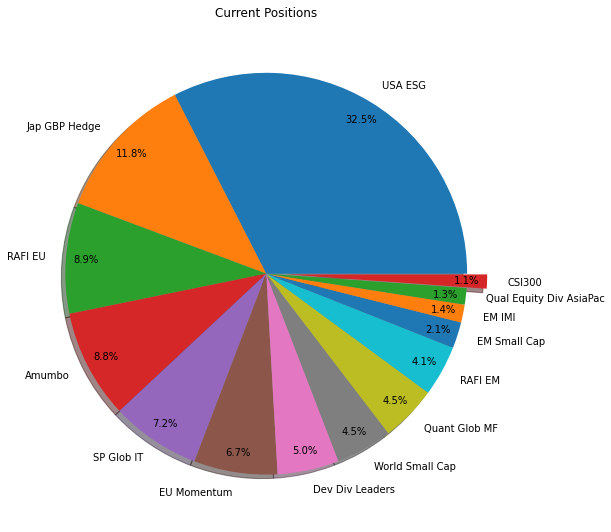

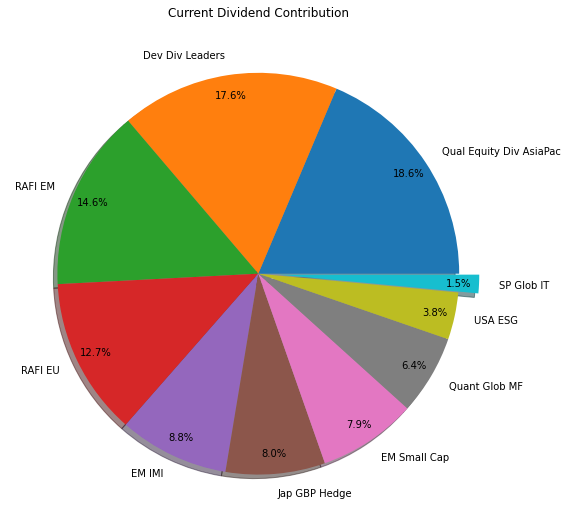

In [5]:
genPiePlot(pos,tick,"Current Positions")
genPiePlot(divCon,tick,"Current Dividend Contribution",filter=True)

In [6]:
total_val,total_divy,alloc = getTotalsAndAlloc(pos,divy)
start_pos = pos

printPortfolioStats(total_val,total_divy,prefix=["Current ","This Year's "])

Current Portfolio Value is 16163.22€
Current Portfolio Yield is 1.69%
This Year's Expected Dividends are 272.54€


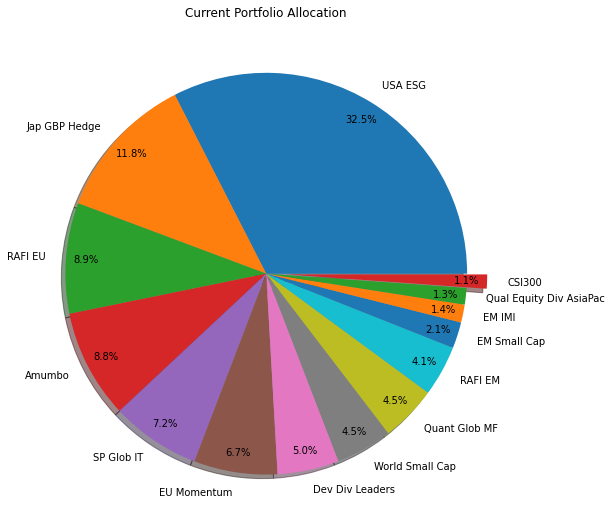

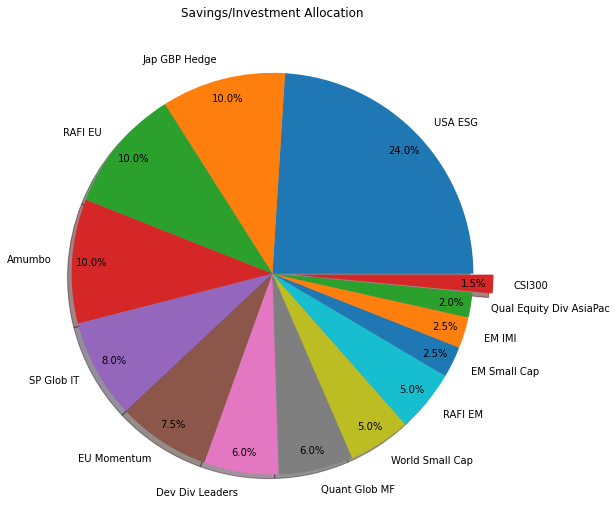

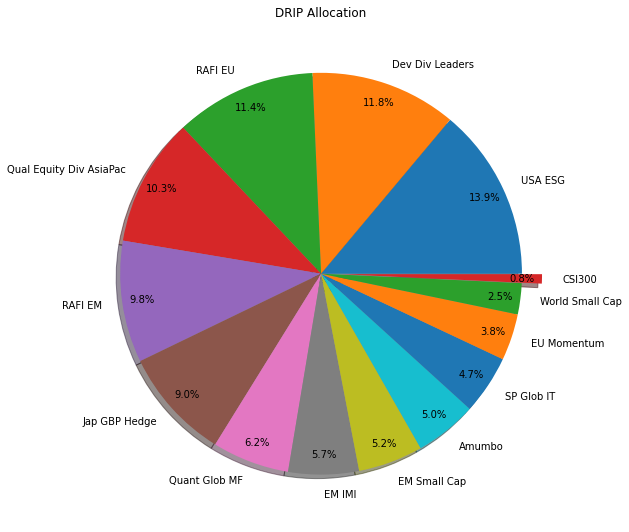

In [7]:
start_alloc = alloc
DRIP_alloc = (divCon+save_alloc)/2
growthDist = (DRIP_alloc+save_alloc+start_alloc)/3
expGrowthFactor = sum(expGrowth*growthDist)
realisticGrowthFactor = sum(realisticGrowth*growthDist)

genPiePlot(start_alloc,tick,"Current Portfolio Allocation")
genPiePlot(save_alloc,tick,"Savings/Investment Allocation")
genPiePlot(DRIP_alloc,tick,"DRIP Allocation",filter=True)

In [8]:
afterTaxMult = (100 - tax)/100
ysr = monthlySavingsRate*12
pos = np.array(pos)

print("Defensive Portfolio growth estimation = {:.2f}%".format(realisticGrowthFactor))
print("Expect Portfolio to grow {:.2f}%".format(expGrowthFactor))

Defensive Portfolio growth estimation = 7.17%
Expect Portfolio to grow 9.05%


## Simple Extrapolated Future Portfolio Predcition via Simulation with Expected Parameters (Bullish)

Reached free rolling Snowball-Effect after 23 years.



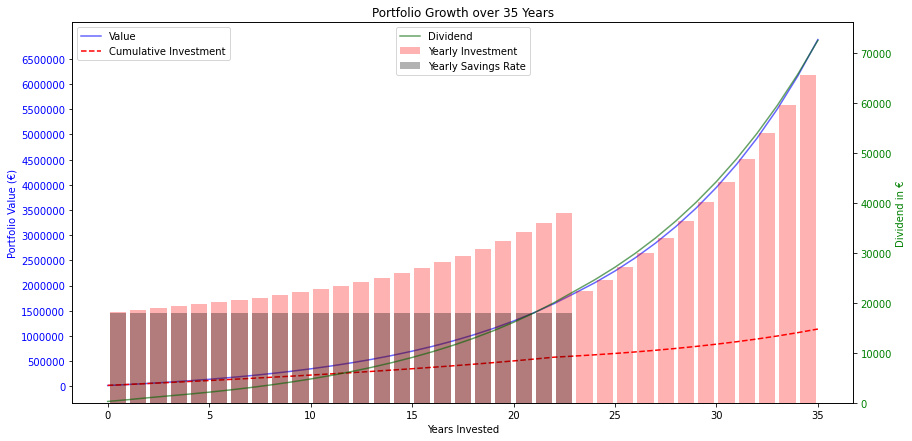

In [9]:
pos,total_val,total_divy,alloc,snowBallCutOff, pos_history,val_hist,adiv_hist,invest_alloc_hist = growthSimulation(years, start_pos, 
    divy, DRIP_alloc, save_alloc, ysr, expGrowth, taxFreeGain, afterTaxMult)
plot_hist(val_hist,adiv_hist,invest_alloc_hist,ysr,snowBallCutOff,years)

After 35 years:
Future Portfolio Value is 6882662.95€
Future Portfolio Yield is 1.42%
Future Expected Dividends are 97681.32€


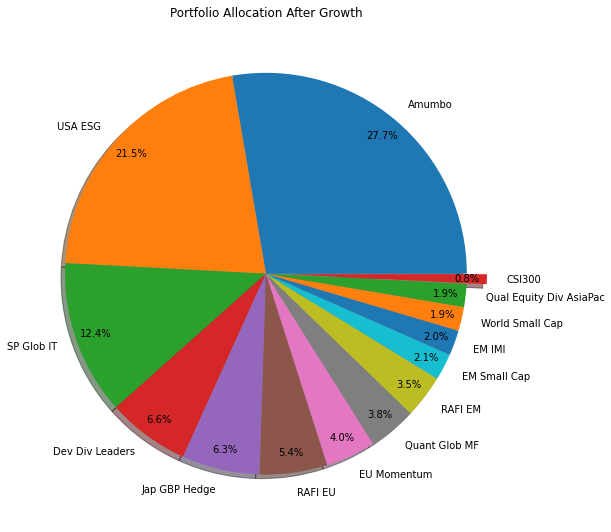

In [10]:
print("After",years,"years:")
printPortfolioStats(total_val,total_divy,prefix=["Future ","Future "])

genPiePlot(alloc,tick,"Portfolio Allocation After Growth")

### Detailed Position Growth Analysis

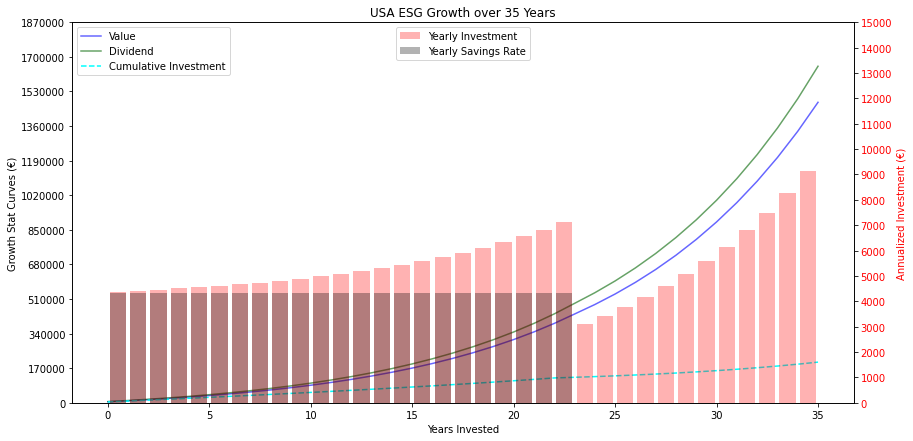

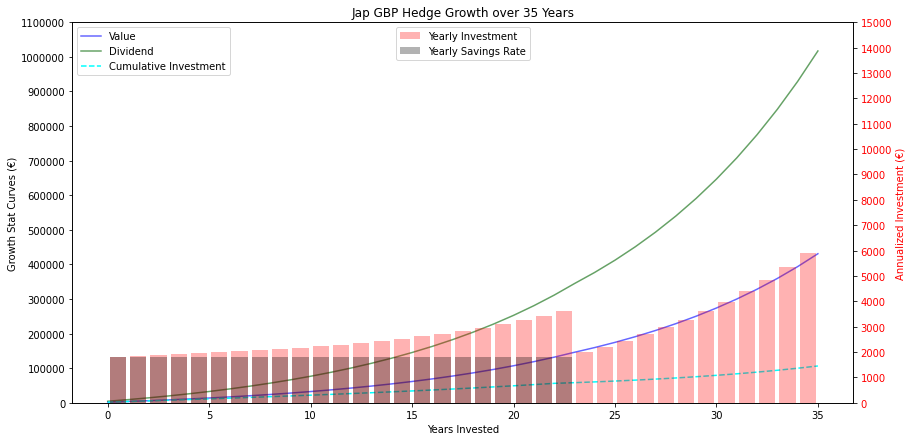

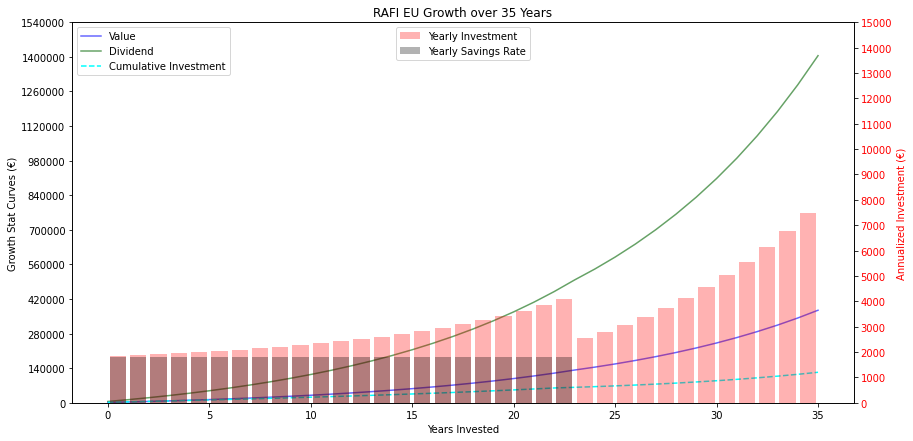

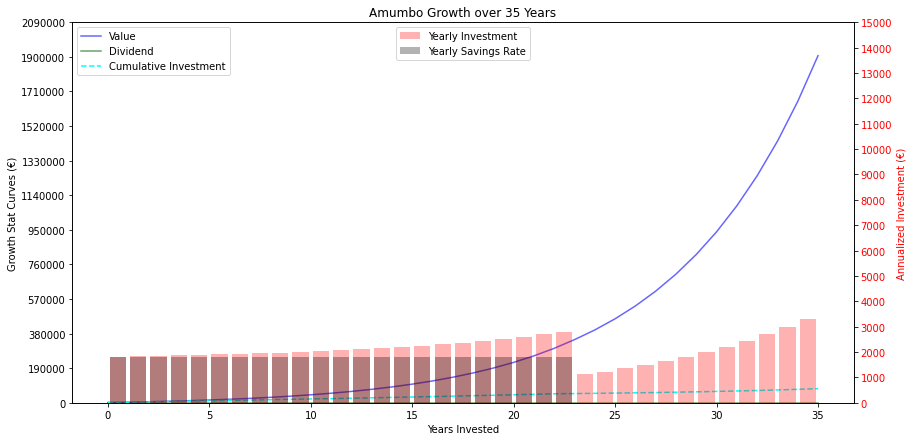

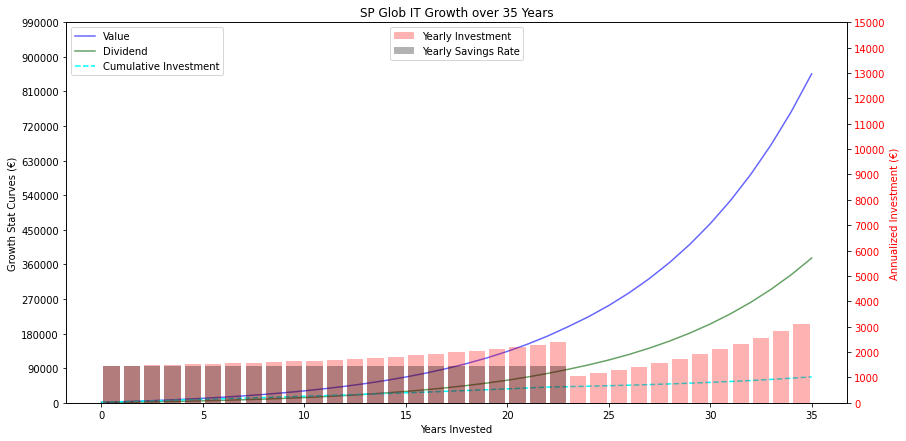

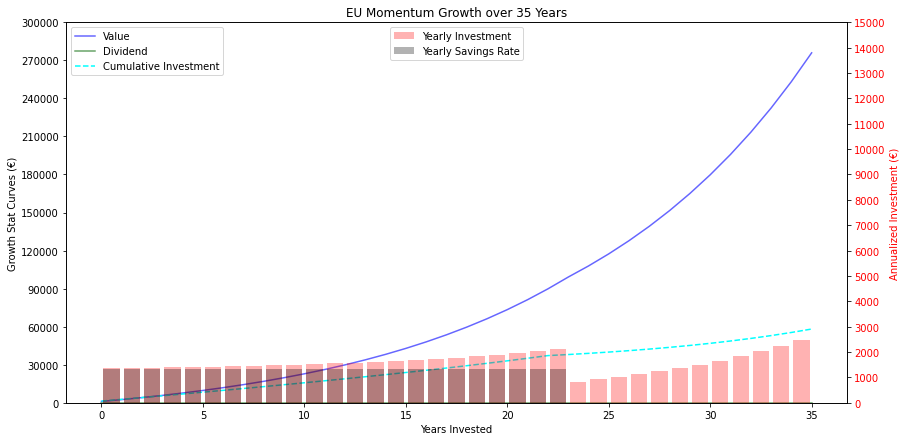

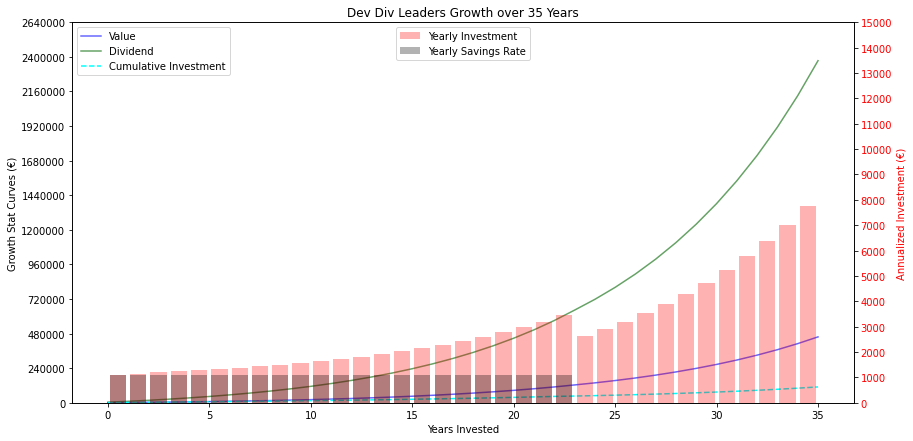

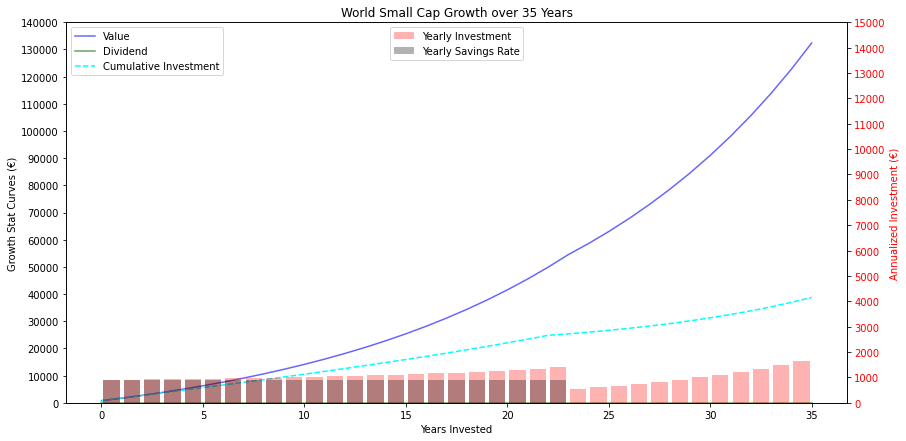

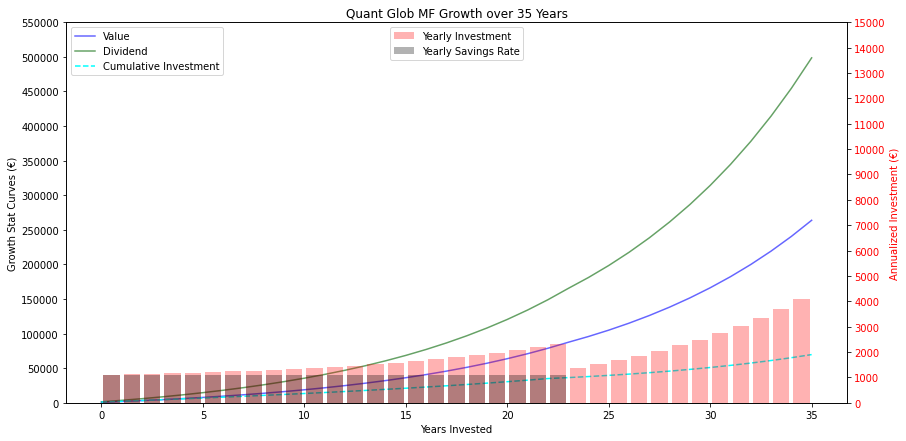

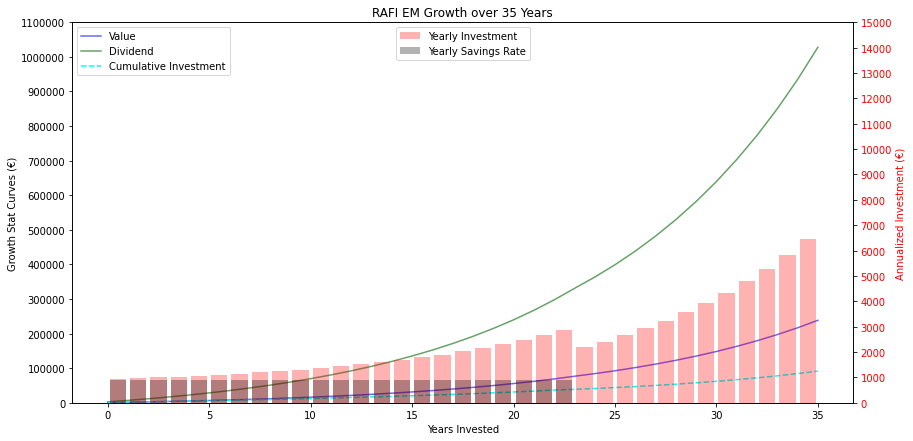

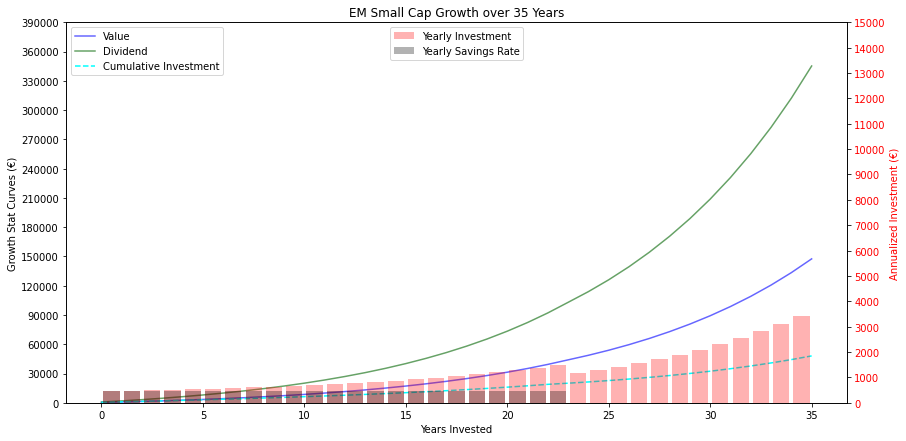

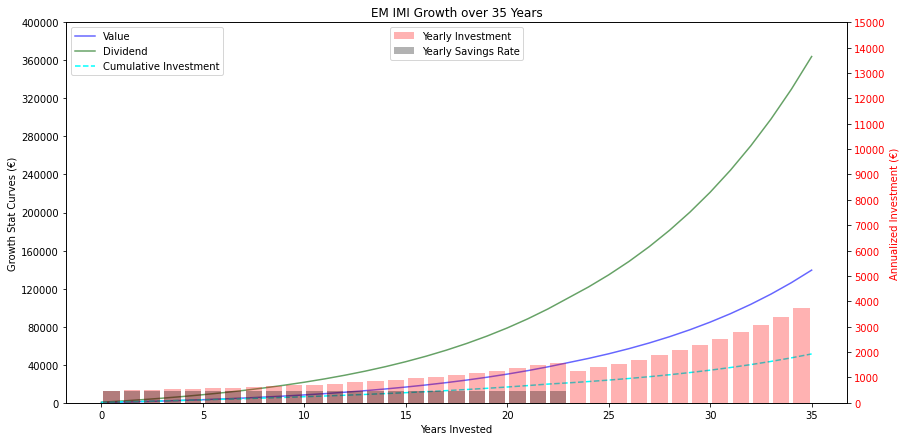

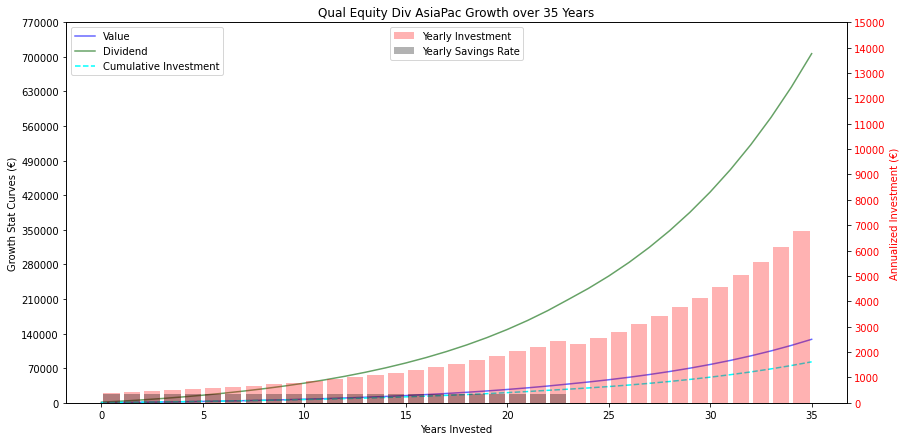

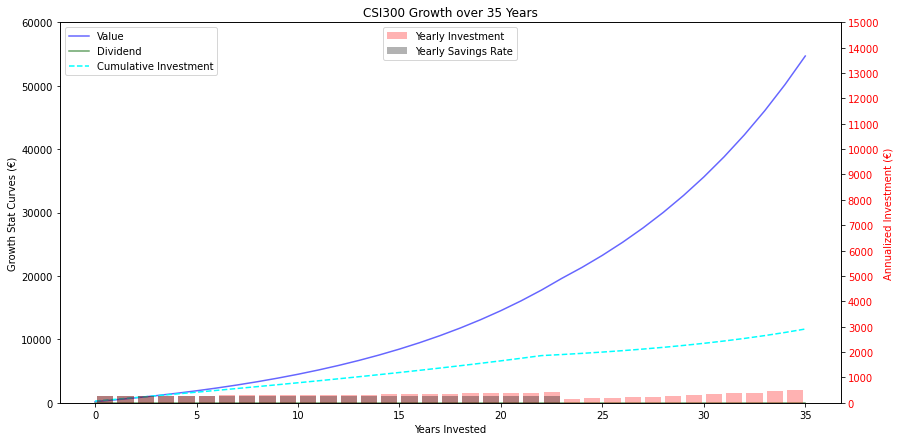

In [11]:
plot_single_pos_hist(tick,pos_history,divy,invest_alloc_hist,save_alloc,ysr,snowBallCutOff,years)

## Retirement Restructuring

Retire and sell non-dividend positions for High Yield World ETF:
Portfolio Value is 6315878.70€
Portfolio Yield is 2.55%
Expected Dividends are 160776.38€


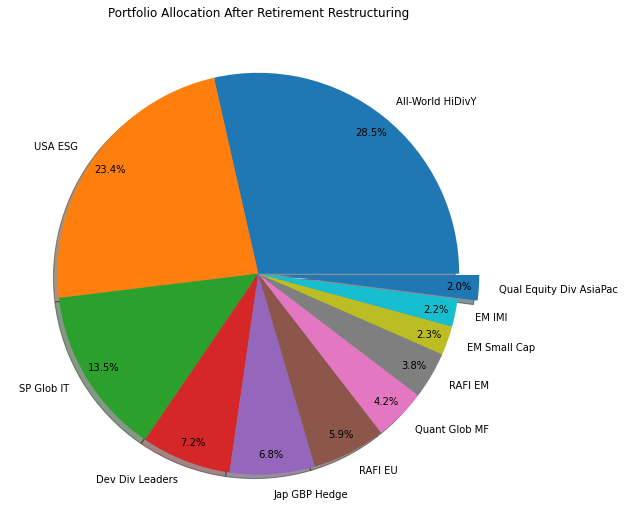

In [12]:
retire_pos,retire_divy,retire_tick = retirementRestructuring(tick,pos,divy,ysr,snowBallCutOff,afterTaxMult,
                                        start_pos,save_alloc,DRIP_alloc,adiv_hist)
retire_total_val,retire_total_divy,retire_alloc = getTotalsAndAlloc(retire_pos,retire_divy)

print("Retire and sell non-dividend positions for High Yield World ETF:")
printPortfolioStats(retire_total_val,retire_total_divy)
genPiePlot(retire_alloc,retire_tick,"Portfolio Allocation After Retirement Restructuring")

## Simple Extrapolated Future Portfolio Predcition via Simulation with Expected Parameters (Bearish)

Reached free rolling Snowball-Effect after 26 years.



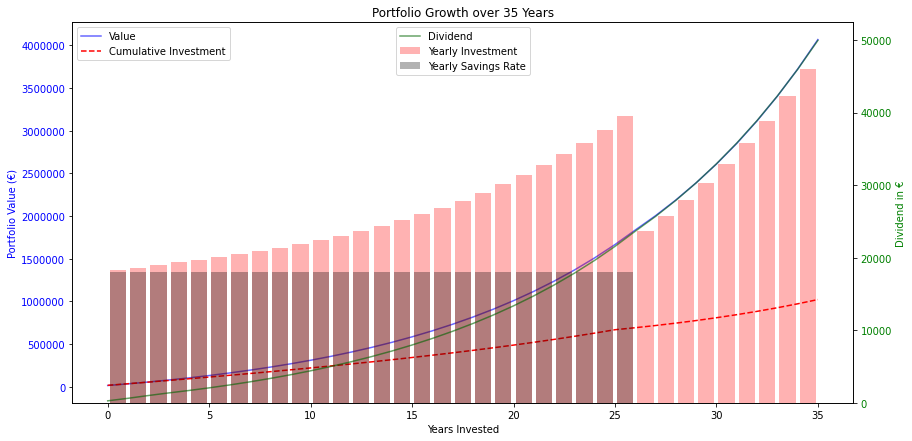

In [13]:
pos,total_val,total_divy,alloc,snowBallCutOff, pos_history,val_hist,adiv_hist,invest_alloc_hist = growthSimulation(years, start_pos, 
    divy, DRIP_alloc, save_alloc, ysr, realisticGrowth, taxFreeGain, afterTaxMult)
plot_hist(val_hist,adiv_hist,invest_alloc_hist,ysr,snowBallCutOff,years)

After 35 years:
Future Portfolio Value is 4066564.34€
Future Portfolio Yield is 1.65%
Future Expected Dividends are 67060.18€


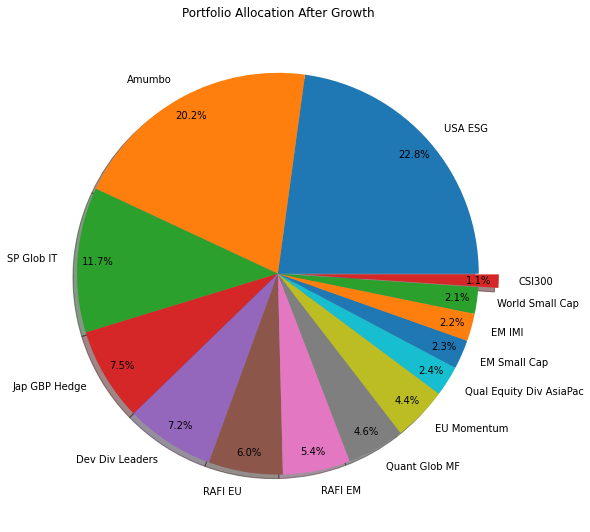

In [14]:
print("After",years,"years:")
printPortfolioStats(total_val,total_divy,prefix=["Future ","Future "])

genPiePlot(alloc,tick,"Portfolio Allocation After Growth")

### Detailed Position Growth Analysis

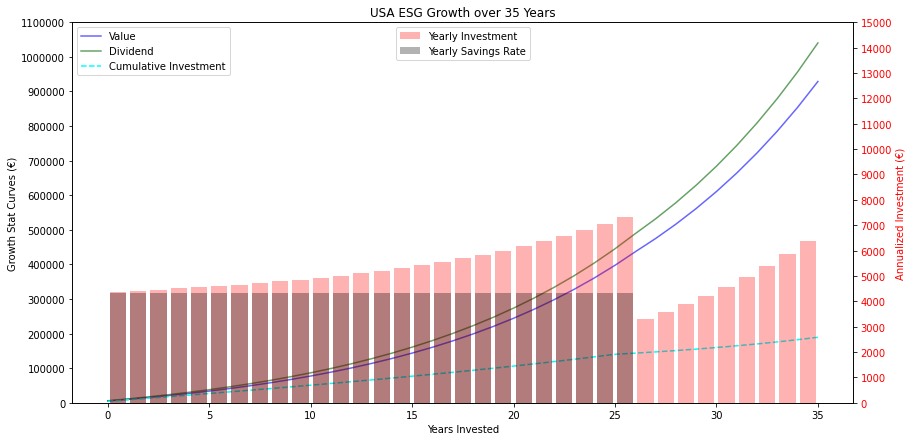

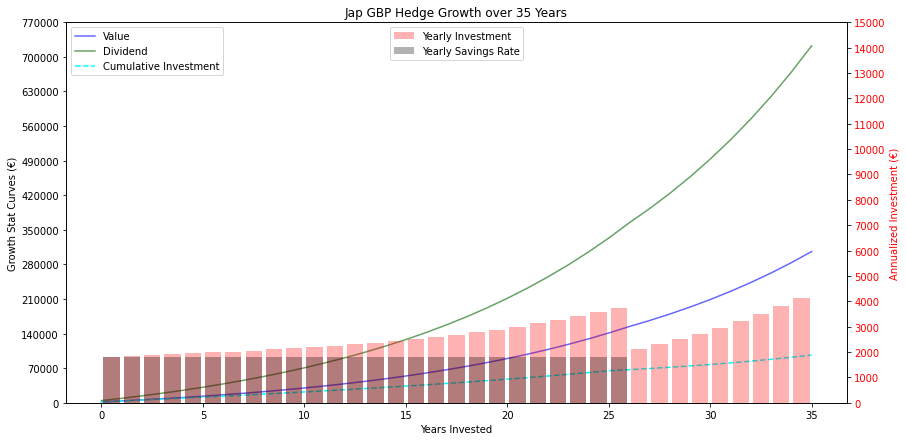

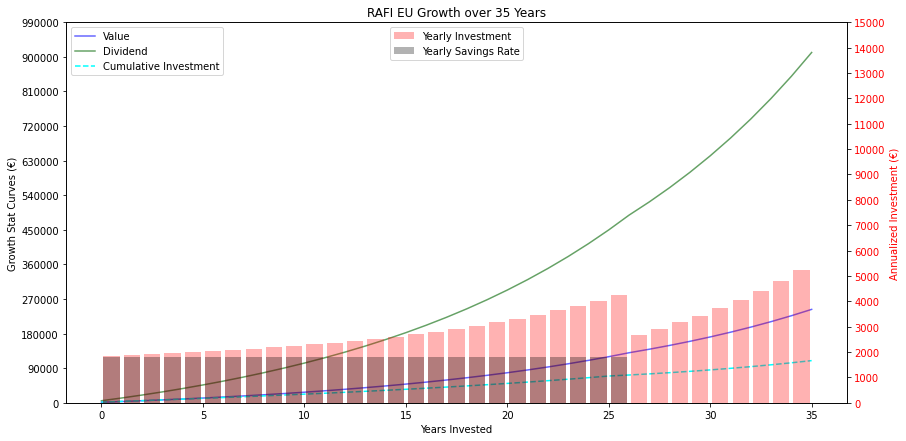

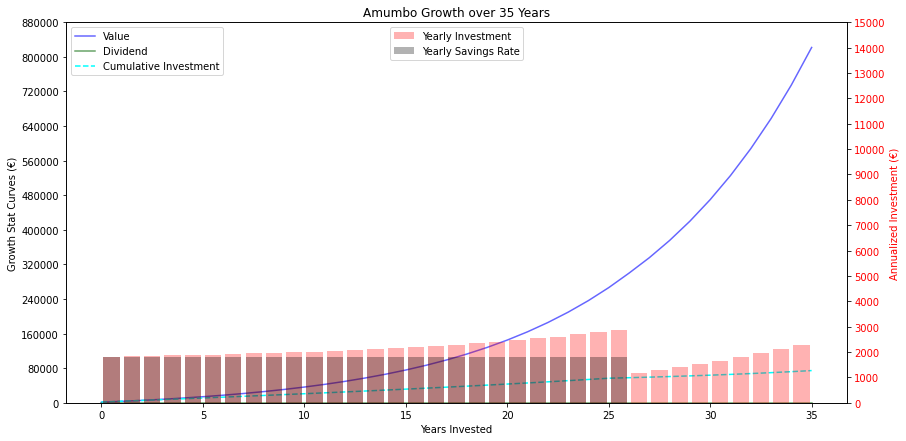

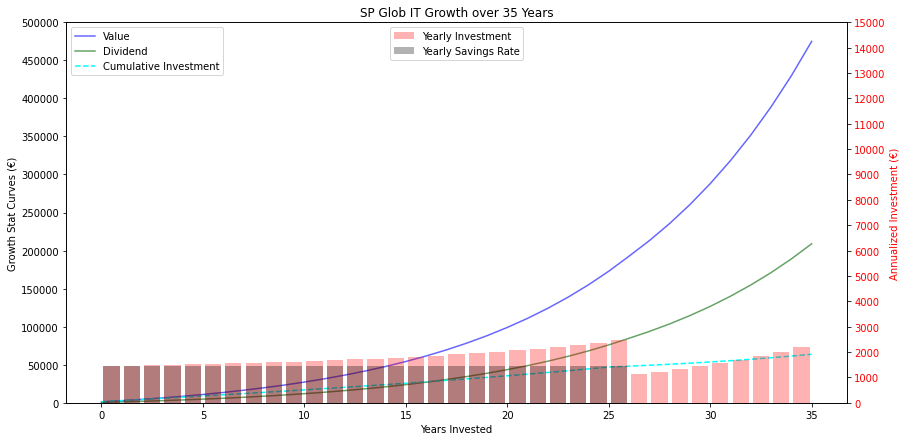

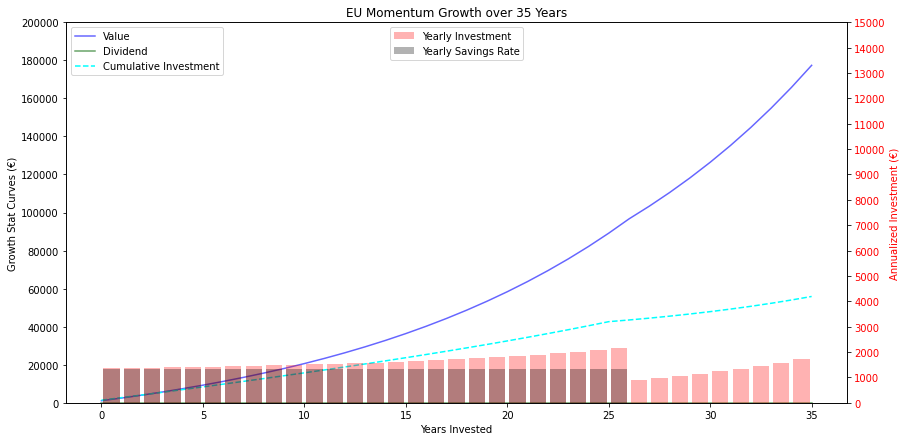

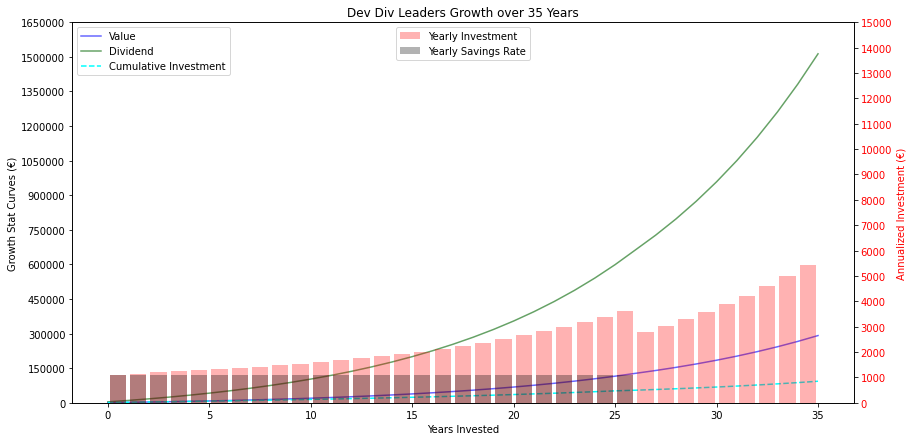

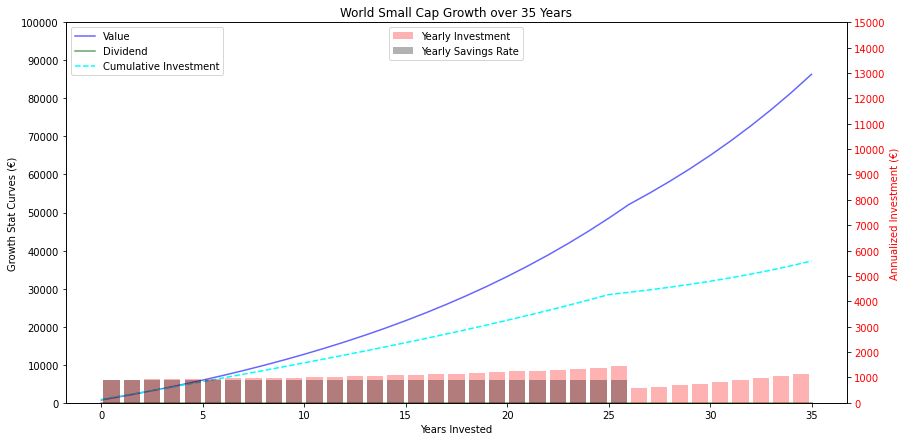

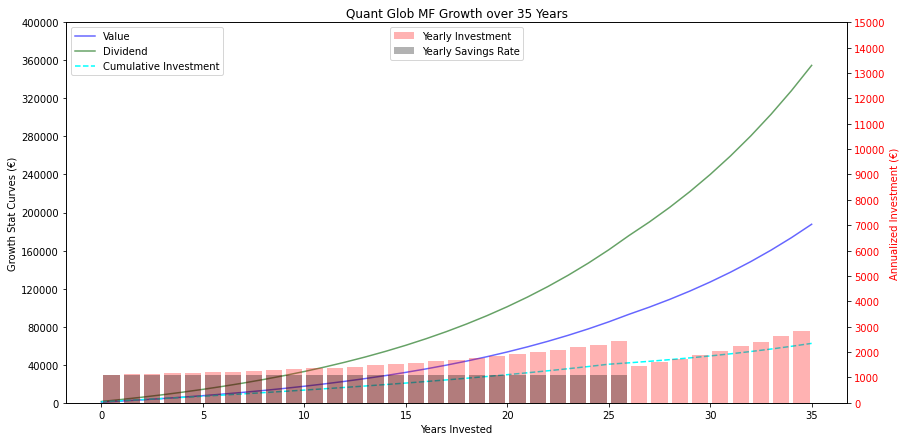

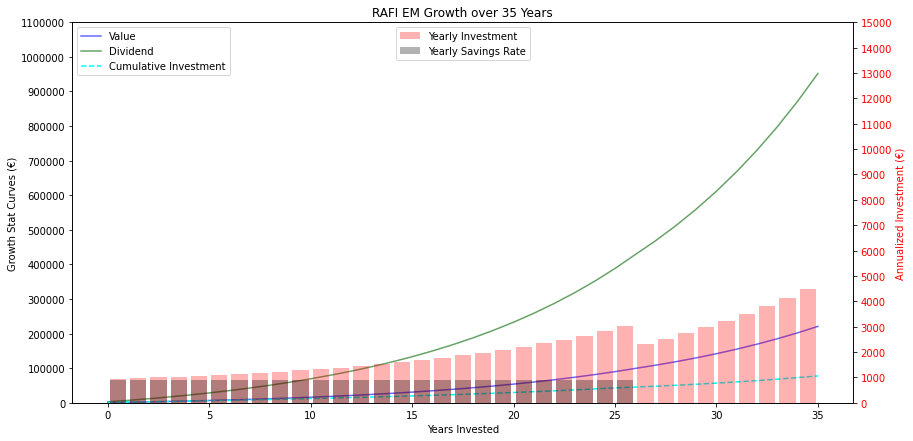

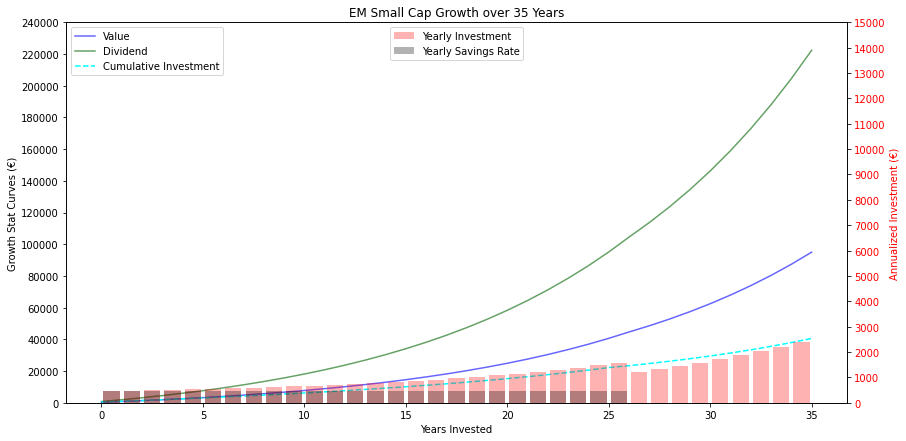

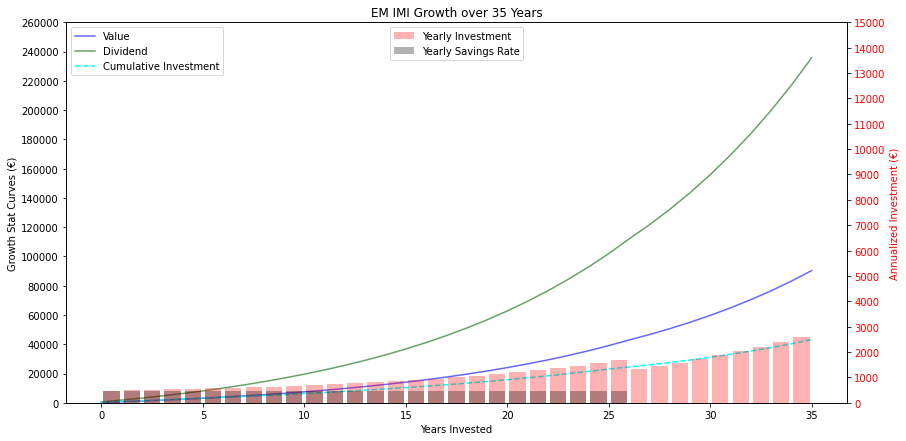

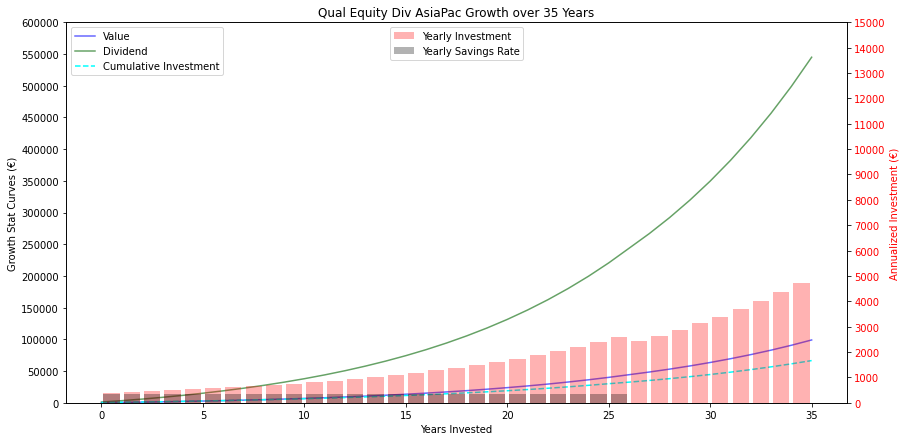

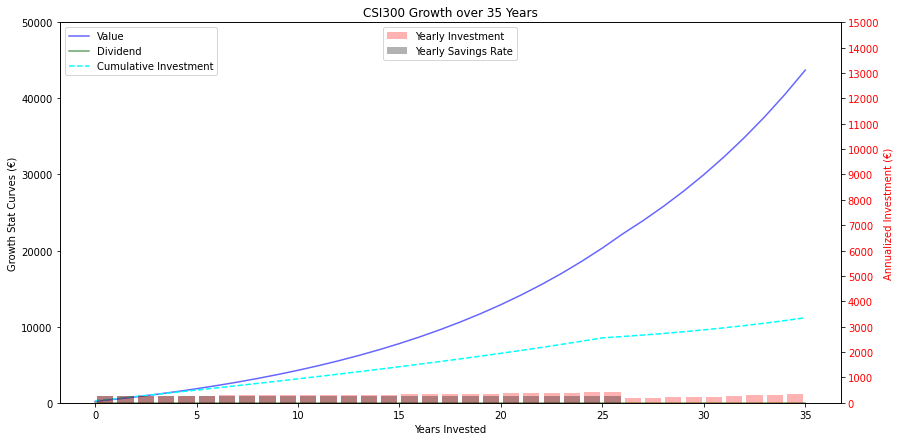

In [15]:
plot_single_pos_hist(tick,pos_history,divy,invest_alloc_hist,save_alloc,ysr,snowBallCutOff,years)

## Retirement Restructuring

Retire and sell non-dividend positions for High Yield World ETF:
Portfolio Value is 3820366.11€
Portfolio Yield is 2.56%
Expected Dividends are 97964.94€


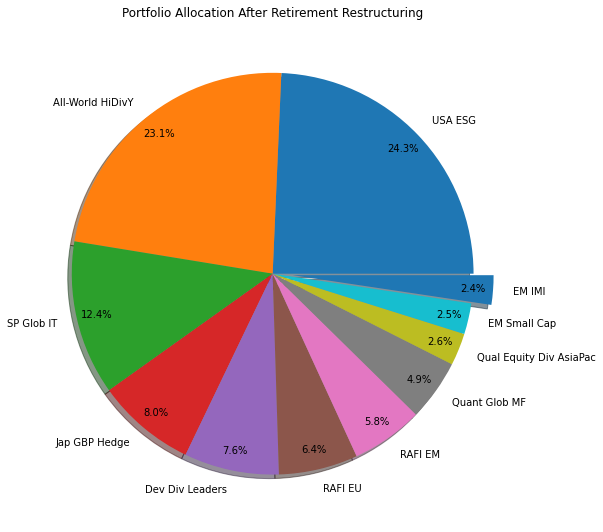

In [16]:
retire_pos,retire_divy,retire_tick = retirementRestructuring(tick,pos,divy,ysr,snowBallCutOff,afterTaxMult,
                                        start_pos,save_alloc,DRIP_alloc,adiv_hist)
retire_total_val,retire_total_divy,retire_alloc = getTotalsAndAlloc(retire_pos,retire_divy)

print("Retire and sell non-dividend positions for High Yield World ETF:")
printPortfolioStats(retire_total_val,retire_total_divy)
genPiePlot(retire_alloc,retire_tick,"Portfolio Allocation After Retirement Restructuring")